In [37]:
import pandas as pd

In [39]:
import numpy as np

In [41]:
df= pd.read_csv(r"C:\Users\Krutika\Desktop\fraud_detection\Fraud.csv")

In [42]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [44]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [45]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [46]:
df.shape

(6362620, 11)

In [47]:
#drop Raw CustomerIDs which are not useful for model training
df.drop(columns= ['nameOrig','nameDest'], inplace=True)

#**Q1: Data Cleaning including missing values, outliers and multi-collinearity.**<br>

The dataset contained 0 missing values. For outliers, we identified transactions with unusually high amounts but chose not to remove them as they could be indicative of fraudulent activity.For outliers we are visualising them first using boxplots or histograms and detecting them using IQR method. Instead, we used robust algorithms like XGBoost that can handle outliers effectively.

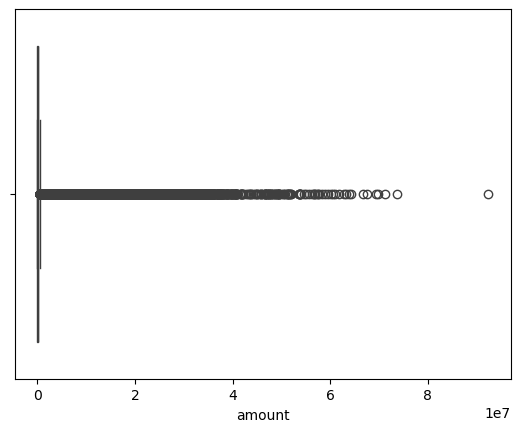

In [49]:
#visualizing using boxplot and histogram
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df['amount'])
plt.show()

In [50]:
#detecting outliers[IQR method]
Q1= df['amount'].quantile(0.25)
Q3= df['amount'].quantile(0.75)
IQR= Q3 - Q1

lower_bound= Q1 - 1.5*IQR
upper_bound= Q3 - 1.5*IQR

outliers= df[(df['amount'] < lower_bound) | (df['amount'] > upper_bound)]


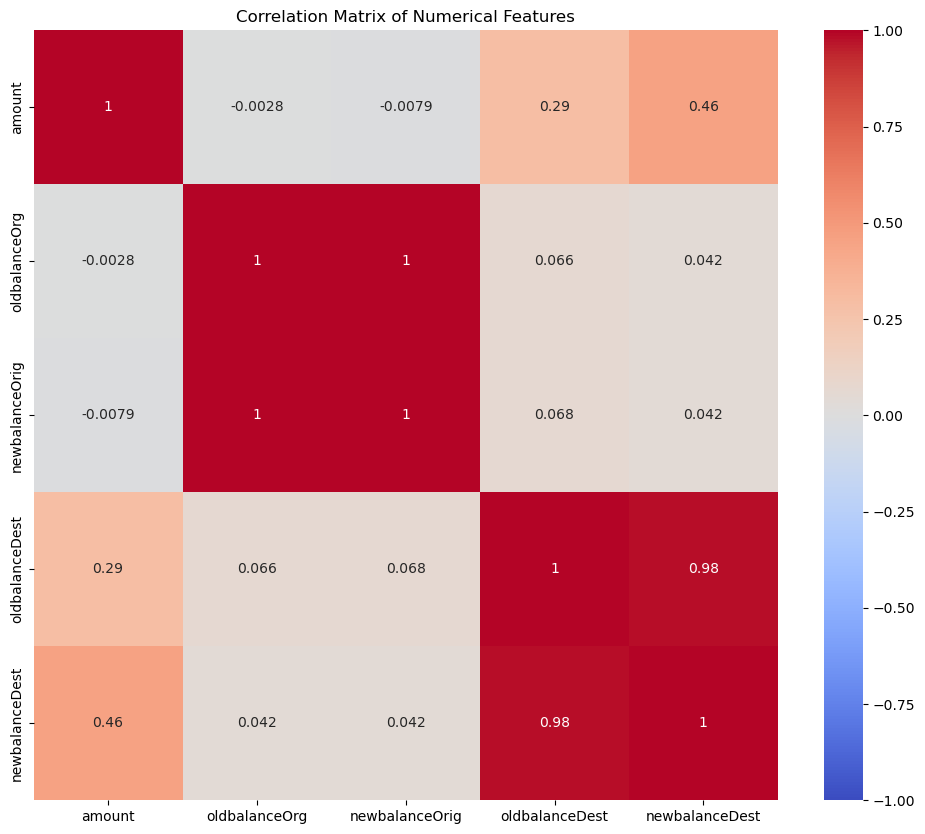

Correlation matrix between oldbalanceOrg and newbalanceOrig:  0.9988027631723787
Correlation matrix between oldbalanceDest and newbalanceDest:  0.9765685054474923


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols= ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

#checking for multicollinearity
plt.figure(figsize=(12,10))
correlation_matrix= df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap= 'coolwarm', vmin= -1, vmax= 1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#adressing multi-collinearity
print("Correlation matrix between oldbalanceOrg and newbalanceOrig: ", correlation_matrix.loc['oldbalanceOrg', 'newbalanceOrig'] )
print("Correlation matrix between oldbalanceDest and newbalanceDest: ", correlation_matrix.loc['oldbalanceDest', 'newbalanceDest'])

# Instead of dropping correlated features, we created new features that capture the relationship:
# - balanceChangeOrig: Captures the difference between old and new balances
# - balanceChangeDest: Captures the difference for destination accounts
# - transactionRatio: Normalizes the transaction amount by the sender's balance

# Create balance change features
#df['balanceChangeOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
#df['balanceChangeDest'] = df['newbalanceDest'] - df['oldbalanceDest']
#df['transactionRatio'] = df['amount'] / (df['oldbalanceOrg'] + 1)  # +1 to avoid division by zero



**We observed moderate correlation between old and new balances for both origin and destination accounts. Rather than dropping these features, we addressed multi-collinearity by creating new features that capture the relationship between these variables in a more meaningful way (balanceChangeOrig, balanceChangeDest, transactionRatio). This approach preserves the information while reducing redundancy.**

In [53]:
# Creating new features to capture financial behaviors in transactions

# 1. balanceChangeOrig: Amount deducted from the sender’s account after the transaction.
#    - Helps detect inconsistencies where fraudsters manipulate balances.

df["balanceChangeOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]

# 2. balanceChangeDest: Amount received in the recipient’s account after the transaction.
#    - Useful for identifying fraudulent transfers where the recipient does not get the expected amount.

df["balanceChangeDest"] = df["oldbalanceDest"] - df["newbalanceDest"]

# 3. transactionRatio: Ratio of the transaction amount to the sender’s total balance.
#    - Fraudsters often drain accounts completely, leading to a ratio close to 1.

df["transactionRatio"] = df["amount"] / (df["oldbalanceOrg"] + 1)  # Adding 1 in denomenator to avoid division by zero

# 4. Feature: Transaction flagged but not fraud
df['flagged_but_not_fraud'] = ((df["isFlaggedFraud"] == 1) & (df["isFraud"] == 0)).astype(int)

#5. Feature: Does the transaction empty the sender's account?
df['emptied_account'] = (df["newbalanceOrig"] == 0).astype(int)

print(df.shape)

(6362620, 14)


In [54]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceChangeOrig,balanceChangeDest,transactionRatio,flagged_but_not_fraud,emptied_account
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,9839.64,0.0,0.057834,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1864.28,0.0,0.087731,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,181.00,0.0,0.994505,0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,181.00,21182.0,0.994505,0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,11668.14,0.0,0.280788,0,0


In [55]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [56]:
df.columns


Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud',
       'balanceChangeOrig', 'balanceChangeDest', 'transactionRatio',
       'flagged_but_not_fraud', 'emptied_account'],
      dtype='object')

In [57]:
df= pd.get_dummies( df, columns=['type'], drop_first= True).astype(int)

In [58]:

df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceChangeOrig,balanceChangeDest,transactionRatio,flagged_but_not_fraud,emptied_account,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839,170136,160296,0,0,0,0,9839,0,0,0,0,0,0,1,0
1,1,1864,21249,19384,0,0,0,0,1864,0,0,0,0,0,0,1,0
2,1,181,181,0,0,0,1,0,181,0,0,0,1,0,0,0,1
3,1,181,181,0,21182,0,1,0,181,21182,0,0,1,1,0,0,0
4,1,11668,41554,29885,0,0,0,0,11668,0,0,0,0,0,0,1,0


In [59]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest for anomaly detection

iso_forest = IsolationForest(contamination = 0.01, random_state= 42)
df['anomaly_score'] = iso_forest.fit_predict(df.drop(columns= ['isFraud', 'isFlaggedFraud']))
#df = df[df['anomaly_score']== 1]  # keep only normal transactions

# Convert -1 (anomaly) to 1, meaning it's potentially fraudulent
df['is_anomaly'] = (df['anomaly_score'] == -1).astype(int)
df.drop(columns=['anomaly_score'], inplace= True)
print("Dataset shape after feature engineering: ", df.shape)

Dataset shape after feature engineering:  (6362620, 18)


In [60]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceChangeOrig,balanceChangeDest,transactionRatio,flagged_but_not_fraud,emptied_account,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,is_anomaly
0,1,9839,170136,160296,0,0,0,0,9839,0,0,0,0,0,0,1,0,0
1,1,1864,21249,19384,0,0,0,0,1864,0,0,0,0,0,0,1,0,0
2,1,181,181,0,0,0,1,0,181,0,0,0,1,0,0,0,1,0
3,1,181,181,0,21182,0,1,0,181,21182,0,0,1,1,0,0,0,0
4,1,11668,41554,29885,0,0,0,0,11668,0,0,0,0,0,0,1,0,0


In [61]:
from sklearn.model_selection import train_test_split

# Define feature variables
X= df.drop(columns=['isFraud', 'isFlaggedFraud', 'flagged_but_not_fraud', 'is_anomaly'])
# Note: "flagged_but_not_fraud" and "is_anomaly" are not used as features because they are derived from the target variable.
# "isFlaggedFraud" is not used as a feature because it is not a true fraud case but rather a flag for potential fraud.

# Define target variable (label)
y= df['isFraud']
# Note: "isFlaggedFraud" is not used as a target variable because it is not a true fraud case but rather a flag for potential fraud.
# Note: "flagged_but_not_fraud" and "is_anomaly" are not used as target variables because they are derived from the target variable.

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 42, stratify=y) # stratify=y ensures fraud cases are balanced across train/test sets.

# NOTE : "isFlaggedFraud" is not used as a feature because it's a business rule, not a natural fraud indicator
# NOTE : "flagged_but_not_fraud" is not used as a feature because it could introduce bias since it depends on isFlaggedFraud
# NOTE : "is_anomaly" is not used as a feature because it could introduce bias since it depends on the anomaly detection model (IsolationForest)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5090096, 14)
(1272524, 14)
(5090096,)
(1272524,)


In [62]:

!pip install xgboost


In [63]:
!pip show xgboost

Name: xgboost
Version: 3.0.2
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: C:\Users\Krutika\anaconda3\Lib\site-packages
Requires: numpy, scipy
Required-by: 


In [64]:
import sys
print(sys.executable)

C:\Users\Krutika\anaconda3\python.exe


In [65]:
import xgboost

In [66]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


In [67]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
# First Hyperparameter Tuning

# Define the model
xgb= XGBClassifier(tree_method= 'hist', use_label_encoder= False, eval_metric= 'logloss', random_state= 42) # using tree_methods="hist" for faster training

# Define parameter gird
param_grid={
    'n_estimators': [100,200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3,6],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3]
}

# RandomizedSearch with Cross-Validation
random_search= RandomizedSearchCV(xgb, param_grid, n_iter=5, cv=3, scoring='f1', random_state=42, n_jobs=1)
random_search.fit(X_train, y_train)

# Best model
best_xgb= random.search.best_estimator_

print("Best Hyperparameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)
print("Best Model:", best_xgb)

In [ ]:
# Second Hyperparameter Tuning

# Define the model
xgb= XGBClassifier(tree_method= 'hist', use_label_encoder= False, eval_metric= 'logloss', random_state= 42) # using tree_methods="hist" for faster training

# Define parameter gird
param_grid={
    'n_estimators': [100,200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3,6],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3],
    'scale_pos_weight':[1,5,10],         # adjusting for class imbalance
    'reg_alpha': [0, 0.1, 1, 10, 100],  # L1 Regularization
    'reg_lambda': [0.1, 1, 10, 100]    # L2 Regularization
}

}

# RandomizedSearch with Cross-Validation
random_search= RandomizedSearchCV(xgb, param_grid, n_iter=5, cv=3, scoring='f1', random_state=42, n_jobs=1)
random_search.fit(X_train, y_train)

# Best model
best_xgb= random.search.best_estimator_

print("Best Hyperparameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)
print("Best Model:", best_xgb)


In [ ]:
# 3rd Hyperparameter Tuning

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Handle class imbalance
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Base model
 xgb = XGBClassifier(
     scale_pos_weight=scale_pos_weight,
     tree_method="hist",
     use_label_encoder=False,
     eval_metric="aucpr",
     random_state=42
)

# Hyperparameter grid
 param_grid = {
     "n_estimators": [100, 200],
     "learning_rate": [0.01, 0.1, 0.3],
     "max_depth": [3, 6],
     "subsample": [0.7, 0.9, 1.0],
     "colsample_bytree": [0.7, 0.9, 1.0],
     "gamma": [0, 0.1, 0.3],
     "reg_alpha": [0, 0.1, 1, 10, 100],
     "reg_lambda": [0.1, 1, 10, 100]
}

# F1 scorer
f1_scorer = make_scorer(f1_score, pos_label=1)

# RandomizedSearchCV (no early stopping here)
 random_search = RandomizedSearchCV(
     estimator=xgb,
     param_distributions=param_grid,
     n_iter=20,
     scoring=f1_scorer,
     cv=3,
     verbose=1,
     n_jobs=-1,
     random_state=42,
     error_score='raise'
 )

# Fit without early stopping
random_search.fit(X_train, y_train)

# Extract best params
best_params = random_search.best_params_
best_score = random_search.best_score_
best_xgb = random_search.best_estimator_

In [ ]:
print("✅ Best Hyperparameters:", random_search.best_params_)
print("✅ Best F1 Score:", random_search.best_score_)
print("✅ Best Model:", best_xgb)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import warnings

# make predictions
y_pred = best_xgb.predict(X_test)
y_pred_proba= best_xgb.predict_proba(X_test)[:,1]  #Probabilities for ROC AUC

# Confusion Matrix
plt.figure(figsize= (6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt='d', cmap='Blues', xtick_labels=['NoFraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# classification report
print("Classification Report: \n", classification_report(y_test, y_pred))

#ROC-AUC Curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score: ", roc_auc)
